In [11]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
from matplotlib import animation
import torch
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class expermentDataloader(Dataset):
    def __init__(
        self,
        index_file: str, 
        data_path: str,
        startIndex = 0,
        endIndex = -1
    ):
        self.root_dir = data_path
        self.expermentSikeTrainsIndex = np.array(pd.read_csv(index_file,header=None))[startIndex:endIndex]
        self.spikeTrains = [
            f"{os.path.join(self.expermentSikeTrainsIndex[i][0])}" for i in range(len(self.expermentSikeTrainsIndex)) 
        ]
        self.targets = self.expermentSikeTrainsIndex[:, 1]

    def __getitem__(self, index):
        inputCSVlines = pd.read_csv(os.path.join(self.root_dir,self.spikeTrains[index])).to_numpy()
        targetCSVLines = self.targets[index]
        return inputCSVlines.flatten(), np.array([targetCSVLines])

    def __len__(self):
        return len(self.expermentSikeTrainsIndex)

dataPath = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/allData"
dataPathIndex = "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/allData/index.csv"

# trainingData = expermentDataloader(dataPathIndex,dataPath, startIndex=0, endIndex=156)
trainingData = expermentDataloader(dataPathIndex,dataPath, startIndex=0, endIndex=100)
testData = expermentDataloader(dataPathIndex,dataPath, startIndex=101, endIndex=156)
# input = trainingData[0][0]
# target = trainingData[0][1]
data, target = trainingData[0]
# data, target = testData[0]

In [3]:
print(len(trainingData))
print(len(testData))

100
55


In [4]:
print(np.sum(data))
target

197


array([339])

In [5]:
len(trainingData[0][0])

11999

In [6]:
len(trainingData[1][0])

11999

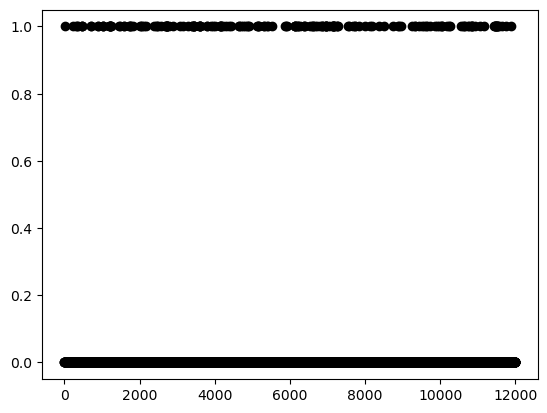

In [7]:
plt.plot(list(range(len(trainingData[0][0]))), trainingData[0][0], 'o', color='black')

In [8]:
target

array([339])

In [9]:
data

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
from torch.utils.data import DataLoader
from sklearn import preprocessing 
batch_size = 10
datasetlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low", 
    startIndex=0, endIndex=70
)
datasetmedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium", 
    startIndex=0, endIndex=60)

datasetHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high", 
    startIndex=0, endIndex=-1
)

print(f"datasetlow:{len(datasetlow)}")
print(f"datasetmedium:{len(datasetmedium)}")
print(f"datasetHigh:{len(datasetHigh)}")
def addData(trainData: list, testData: list, expermentDataset: expermentDataloader, cutoffIndex=None):
    cutoffIndex = int(len(expermentDataset)*0.9) if cutoffIndex == None else cutoffIndex
    
    # print(f"using {len(range(cutoffIndex))} of {len(expermentDataset)} for set a")
    for i in range(cutoffIndex):
        trainData.append(expermentDataset[i])

    # print(f"using {len(range(cutoffIndex, len(expermentDataset)))} of {len(expermentDataset)} for set b")
    for i in range(cutoffIndex, len(expermentDataset)):
        testData.append(expermentDataset[i])

rawData = []
addData(rawData, [], datasetlow, cutoffIndex=len(datasetlow))
addData(rawData, [], datasetmedium, cutoffIndex=len(datasetmedium))
addData(rawData, [], datasetHigh, cutoffIndex=len(datasetHigh))
rawData = [[k,v] for k,v in rawData]
magnetSettings = [1.5] * 27 # 1.5mm_35.14pN
magnetSettings += [2] * 28  # 2mm_22.6pN
magnetSettings += [3] * 16  # 3mm_9.24pN
magnetSettings += [5] * 63  # 5mm_1.46pN
magnetSettings += [9] * 21  # 9mm_0.002pN
magnetSettings = [[i] for i in magnetSettings]

forceSettings = [35.14] * 27  # 1.5mm_35.14pN
forceSettings += [22.6] * 28  # 2mm_22.6pN
forceSettings += [9.24] * 16  # 3mm_9.24pN
forceSettings += [1.46] * 63  # 5mm_1.46pN
forceSettings += [0.002] * 21 # 9mm_0.002pN
forceSettings = [[i] for i in forceSettings]

trains, targets = list(map(list, zip(*rawData)))
# trains = [np.sum(i) for i in trains]
# trains = [[i] for i in trains]
# forceSettings = preprocessing.normalize(forceSettings,axis=0)
# magnetSettings = preprocessing.normalize(magnetSettings,axis=0)
# targets = preprocessing.normalize(targets,axis=0)
tmp = list(zip(trains,magnetSettings,forceSettings))
tmp = list(list(i[0]) + list(i[1]) + list(i[2]) for i in tmp)
rawData = (list(zip(tmp,targets)))
datasetlow = rawData[:len(datasetlow)]
datasetmedium = rawData[len(datasetlow):len(datasetlow)+len(datasetmedium)]
datasetHigh = rawData[len(datasetlow)+len(datasetmedium):]
trainData = []
testData = []
validData = []

addData(trainData, testData, datasetlow, cutoffIndex=int(len(datasetlow)*0.8))
addData(trainData, testData, datasetmedium, cutoffIndex=int(len(datasetmedium)*0.8))
addData(trainData, testData, datasetHigh, cutoffIndex=int(len(datasetHigh)*0.8))
# tmp = copy.deepcopy(testData)
# testData = []
# addData(testData, validData, tmp, cutoffIndex=int(len(tmp)*0.5))
# trains, magnetSettings, forceSettings, targets = list(map(list, zip(*trainData)))
# # trains = preprocessing.normalize(trains)
# magnetSettings = preprocessing.normalize(magnetSettings)
# forceSettings = preprocessing.normalize(forceSettings)
# # targets = preprocessing.normalize(targets)
# tmp = list(zip(trains,magnetSettings,forceSettings))

trainData = [([np.array(i).flatten(), np.array(t)]) for i,t in trainData]
testData = [([np.array(i).flatten(), np.array(t)]) for i,t in testData]
# validData = [([np.array(i).flatten(), np.array(t)]) for i,t in validData]

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True)
testDataset = DataLoader(testData, batch_size=batch_size, shuffle=True)
# validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Testing dataset size: {len(testData)}")
# print(f"Validating dataset size: {len(validData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number test batches:{len(testDataset)}")
# print(f"number valid batches:{len(validDataset)}")

datasetlow:56
datasetmedium:16
datasetHigh:83
Training dataset size: 122
Testing dataset size: 33
number train batches:13
number test batches:4


In [9]:
featIn = len(trainData[0][0])
trainData[0]

[array([ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.5 , 35.14]), array([34])]

In [32]:
device

device(type='cuda', index=0)

In [76]:
model = nn.Sequential(
          nn.Linear(featIn,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,1),
        )
model.to(device)
MSE = nn.MSELoss(reduction = 'sum')
adam = torch.optim.Adam(model.parameters(),lr=0.000001)

em = 20
epochs = 75
losses = []
accs = []
print("training...")
for e in range(epochs): 
    model.train()
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        adam.zero_grad()
        loss.backward()
        adam.step()
        
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        accs.append(float(totalCorrect/len(targets)))
        currentAcc.append(float(totalCorrect/len(targets)))
        losses.append(float(loss.clone().detach().cpu().numpy()))
    print(f"\
            epoch: {e}/{epochs}\t \
            loss:{np.sum(avgLoss)/len(avgLoss)}\t \
            accuracy:{np.sum(currentAcc)/len(currentAcc)} \
            ",end="\x1b\r")
        
    # avgLoss = []
    # currentAcc = []
    # model.eval()
    # for i, (inputs, targets) in enumerate(validDataset):
    #     inputs, targets= inputs.float().to(device), targets.float().to(device)
    #     outputs = model(inputs)
    #     loss = MSE(outputs, targets)
    #     outputPlot = outputs.clone().detach().cpu().numpy()
    #     targetsPlot = targets.clone().detach().cpu().numpy()
    #     avgLoss.append(float(loss.clone().detach().cpu().numpy()))
    #     totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
    #     totalCorrect = totalCorrect.clone().detach().cpu().numpy()
    #     accs.append(float(totalCorrect/len(targets)))
    #     currentAcc.append(float(totalCorrect/len(targets)))
    #     losses.append(float(loss.clone().detach().cpu().numpy()))
    #     print(f"\
    #     epoch: {e}/{epochs}\t \
    #     loss:{np.sum(avgLoss)/len(avgLoss)}\t \
    #     accuracy:{np.sum(currentAcc)/len(currentAcc)} \
    #     ",end="\x1b\r")

training...


In [77]:
from datetime import datetime
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
torch.save(model.state_dict(), f"./Models/{dt_string}.pt")


975

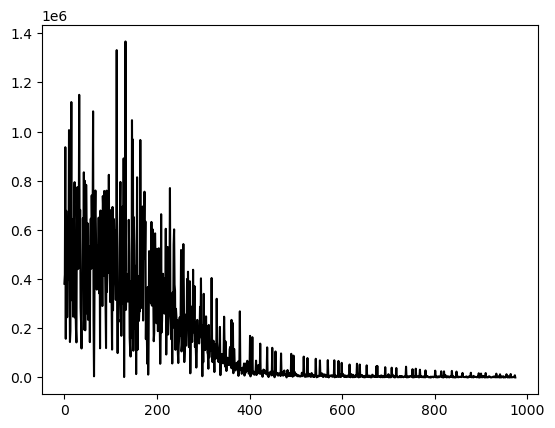

In [78]:
# plt.plot(list(range(len(accs))), accs, '-', color='black')
plt.plot(list(range(len(losses))), losses, '-', color='black')
len(accs)

In [79]:
em =20
epochs = 100
accs = []
model.eval()
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        if(len(outputs) == batch_size):
            outputPlot = outputs.clone().detach().cpu().numpy()
            targetsPlot = targets.clone().detach().cpu().numpy()
            totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
            totalCorrect = totalCorrect.clone().detach().cpu().numpy()
            currentAcc.append(float(totalCorrect/len(targets)))
            accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


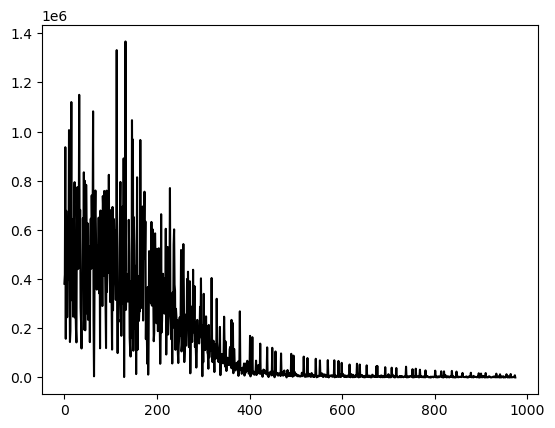

In [80]:
plt.plot(list(range(len(losses))), losses, '-', color='black')

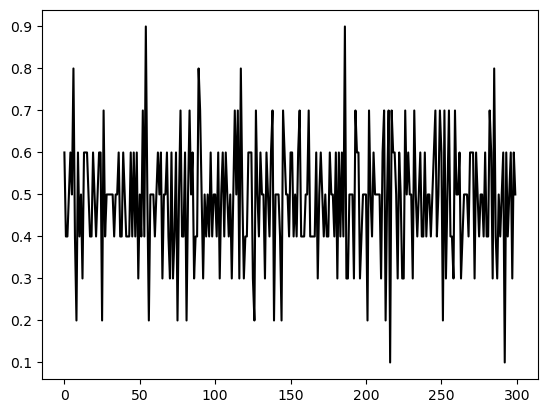

In [81]:
plt.plot(list(range(len(accs))), accs, '-', color='black')

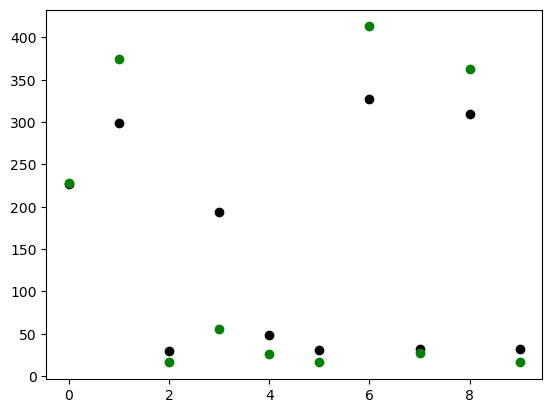

In [82]:
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black')
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green')

In [13]:
device

device(type='cuda', index=0)

In [25]:
model = nn.Sequential(
          nn.Linear(featIn,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,16000),
          nn.ReLU(),
          nn.Linear(16000,1),
        )
PATH = "Models/11.04.2023_01-35-11-455530.pt"
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=12001, out_features=16000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16000, out_features=16000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16000, out_features=16000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16000, out_features=16000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16000, out_features=1, bias=True)
)

#### High
----

In [26]:
testHigh = [i for i in testData if i[0][-2] in [9.0, 5.0]]
testDatasetHigh = DataLoader(testHigh, batch_size=len(testHigh), shuffle=True)
testHigh

[[array([0.  , 0.  , 0.  , ..., 0.  , 5.  , 1.46]), array([20])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([363])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([243])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([375])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([413])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([210])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([155])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([342])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([252])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([55])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([234])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), array([336])],
 [array([0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 9.e+00, 2.e-03]), ar

In [27]:
len(testHigh)

18

In [67]:
em =137
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDatasetHigh):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


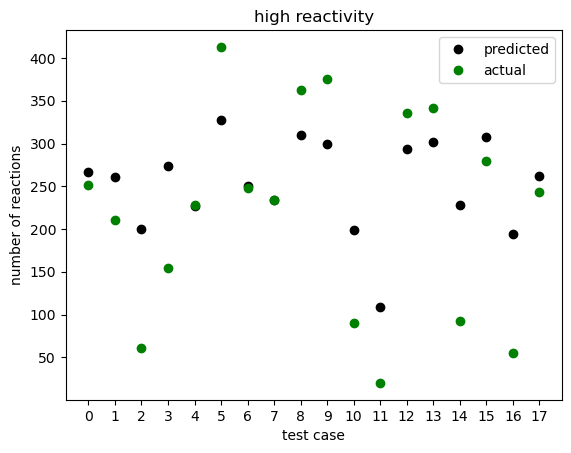

In [69]:
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="actual")
plt.xticks(ticks=list(range(len(outputPlot))), labels=list(range(len(outputPlot))))
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('high reactivity')
plt.legend(loc='upper right')

#### medium
----

In [70]:
testmedium = [i for i in testData if i[0][-2] in [3.0]]
testDatasetmedium = DataLoader(testmedium, batch_size=len(testmedium), shuffle=True)
testmedium

[[array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([26])],
 [array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([153])],
 [array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([93])],
 [array([0.  , 0.  , 0.  , ..., 0.  , 3.  , 9.24]), array([132])]]

In [49]:

em =45
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDatasetmedium):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


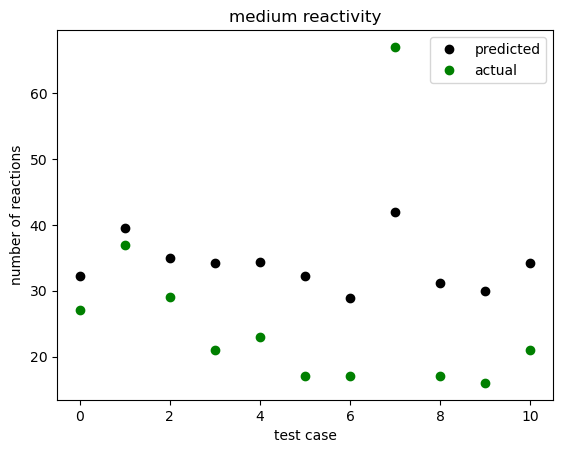

In [65]:
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="actual")
plt.xticks(ticks=list(range(len(outputPlot))), labels=list(range(len(outputPlot))))
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('medium reactivity')
plt.legend(loc='upper right')

#### low
----

In [51]:

testLow = [i for i in testData if i[0][-2] in [2.0,1.5]]
testDatasetLow = DataLoader(testLow, batch_size=len(testLow), shuffle=True)
len(testLow)

11

In [53]:

em =20
epochs = 100
accs = []
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDatasetLow):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

test...


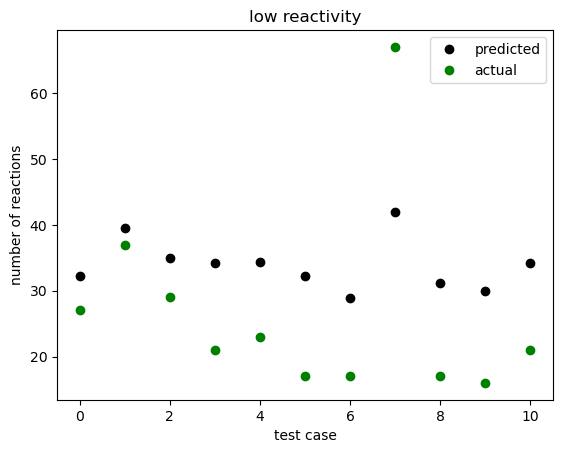

In [64]:
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="actual")
plt.xticks(ticks=list(range(len(outputPlot))), labels=list(range(len(outputPlot))))
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('low reactivity')
plt.legend(loc='upper right')